In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Load the dataset
df = pd.read_csv('../day.csv')

In [3]:
df['weathersit']

0      2
1      2
2      1
3      1
4      1
      ..
725    2
726    2
727    2
728    1
729    2
Name: weathersit, Length: 730, dtype: int64

In [24]:

# Convert season and weathersit to categorical with descriptive labels
df['season'] = df['season'].map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
df['weathersit'] = df['weathersit'].map({
    1: 'clear',
    2: 'mist_cloudy',
    3: 'light_snow_rain',
    4: 'heavy_rain_ice'
})

# Check for missing values
missing_values = df.isnull().sum()

# Display the converted data and missing values
df[['season', 'weathersit']].head(), missing_values

(  season   weathersit
 0    NaN  mist_cloudy
 1    NaN  mist_cloudy
 2    NaN        clear
 3    NaN        clear
 4    NaN        clear,
 instant         0
 dteday          0
 season        730
 yr              0
 mnth            0
 holiday         0
 weekday         0
 workingday      0
 weathersit      0
 temp            0
 atemp           0
 hum             0
 windspeed       0
 casual          0
 registered      0
 cnt             0
 dtype: int64)

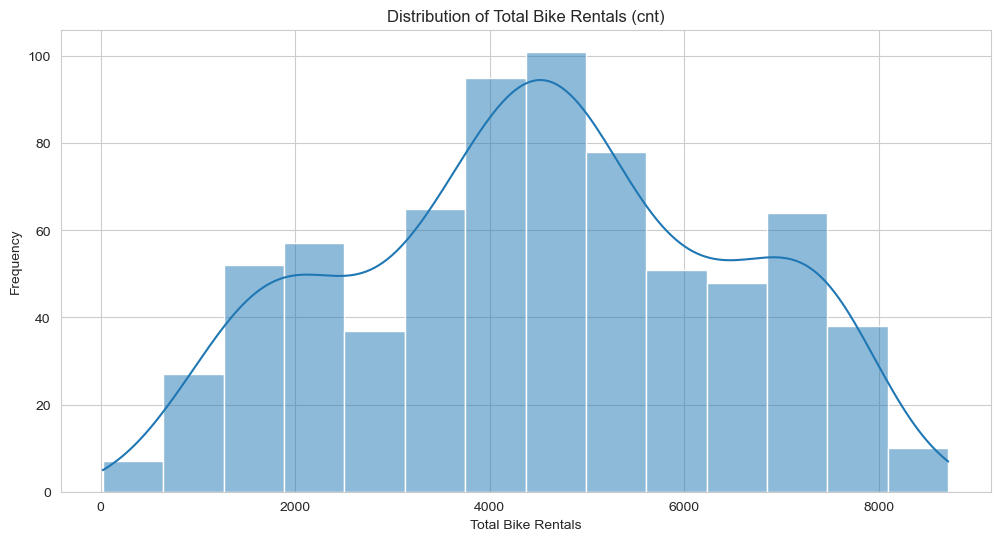

/var/folders/0q/clpdbrcs35q427c4ncjr3ttc0000gn/T/ipykernel_37766/3181095406.py:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


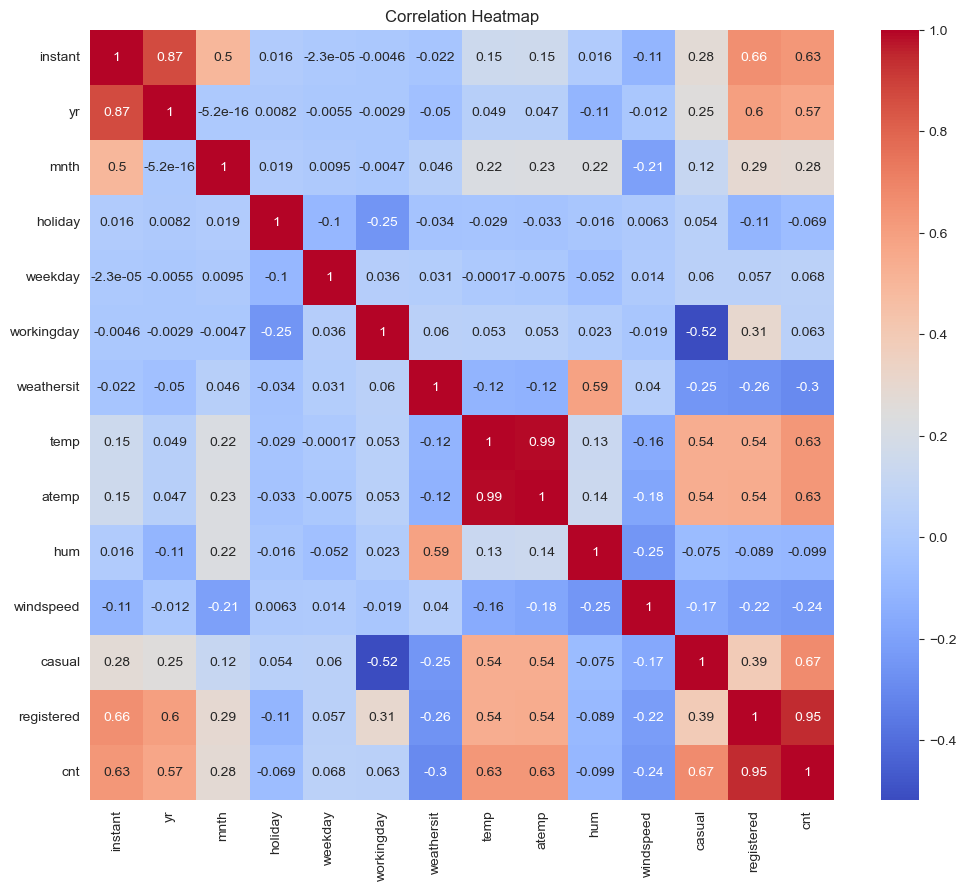

In [6]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Distribution of the target variable 'cnt'
plt.figure(figsize=(12, 6))
sns.histplot(df['cnt'], kde=True)
plt.title('Distribution of Total Bike Rentals (cnt)')
plt.xlabel('Total Bike Rentals')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



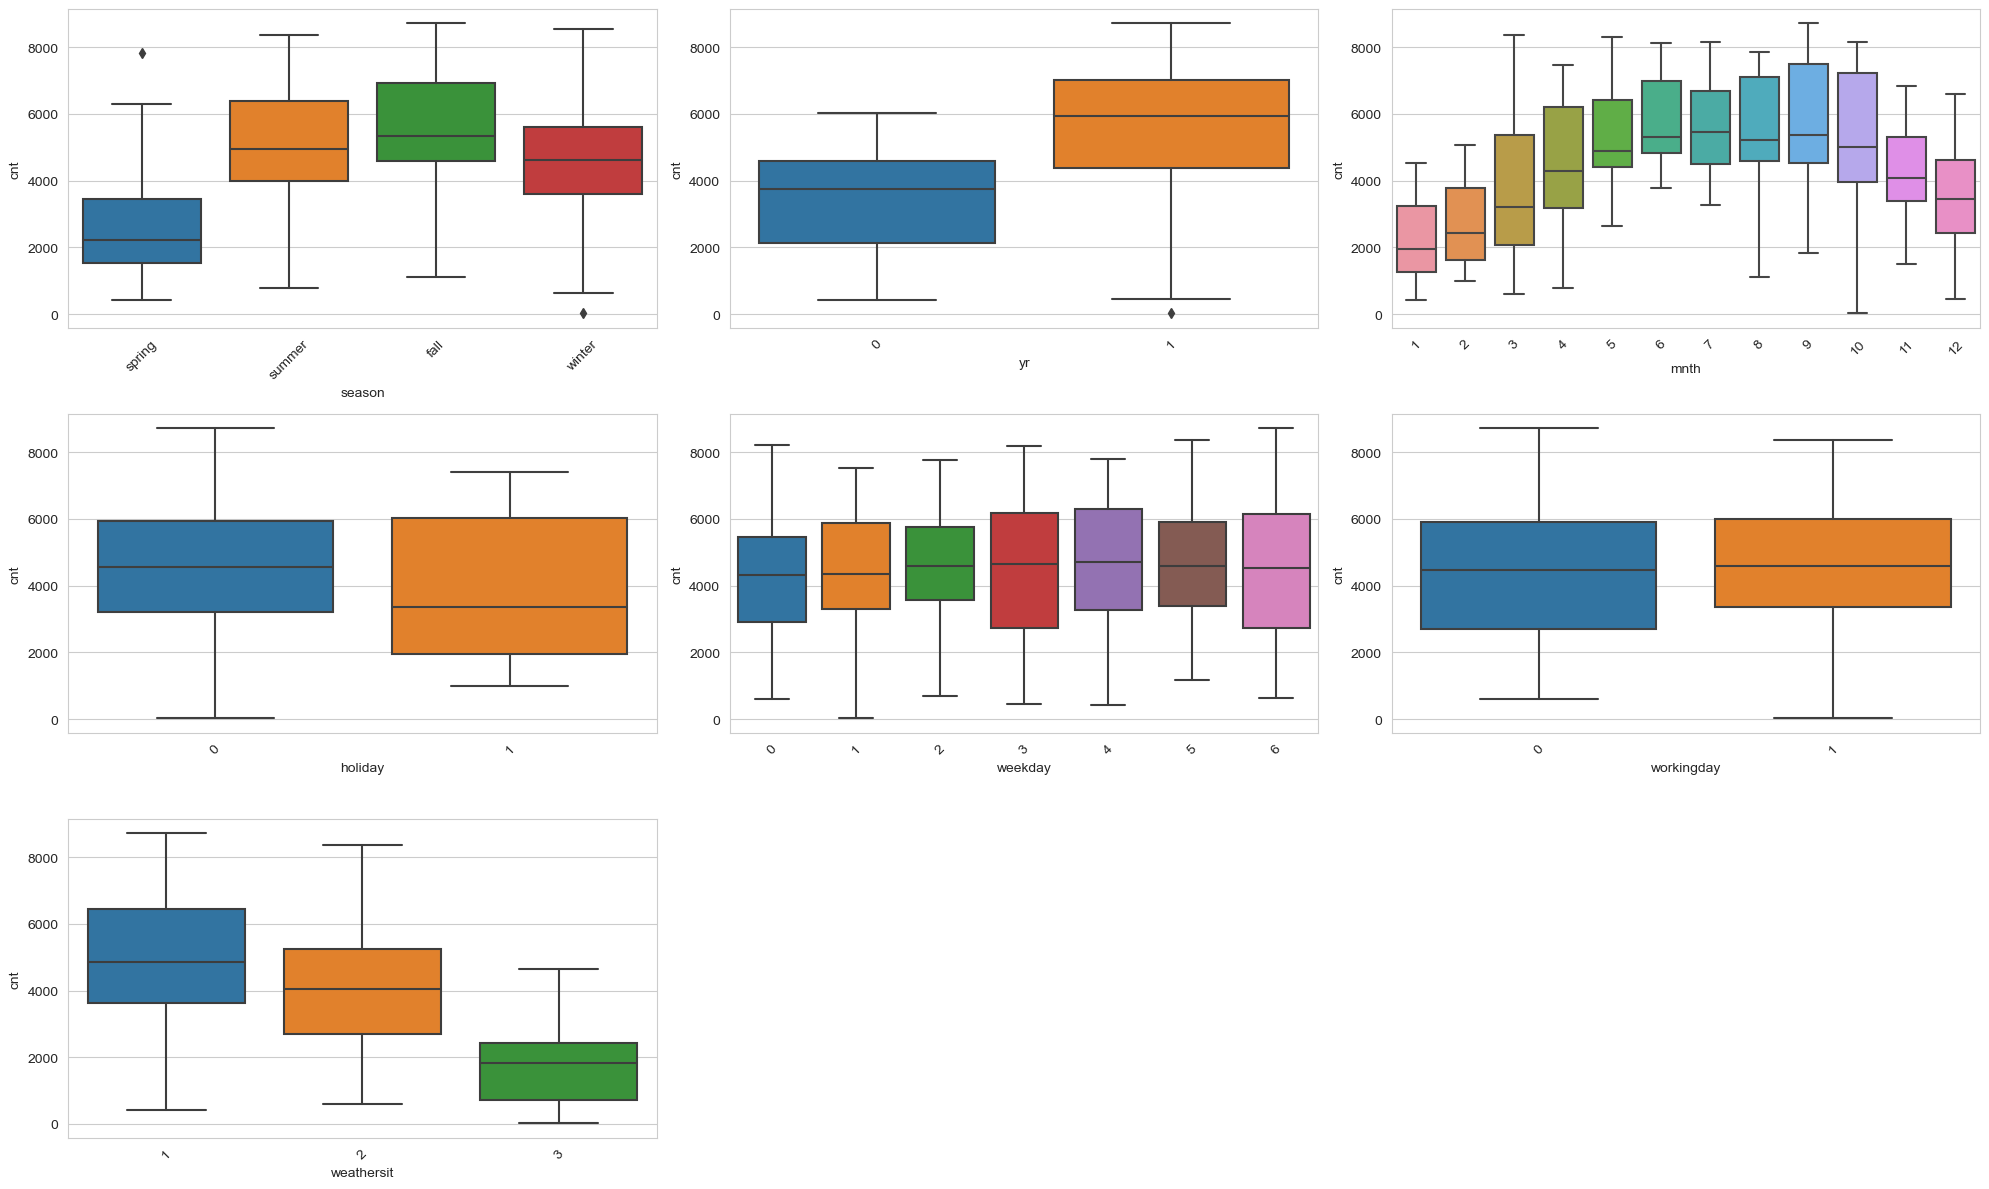

In [7]:
categorical_features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
plt.figure(figsize=(20, 12))
for i, var in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=var, y='cnt', data=df)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The exploratory data analysis (EDA) provides several insights into the dataset:

Distribution of Total Bike Rentals: The distribution of total bike rentals (cnt) shows a somewhat bimodal distribution, indicating that there are days with both high and low demand for bike rentals.

Bike Rentals by Season: The boxplot by season shows that there is a variation in the number of bike rentals across different seasons, with spring and summer appearing to have higher demand compared to winter.

Total Bike Rentals by Year: The bar plot illustrates an increase in total bike rentals from 2018 to 2019, supporting the idea that the yr variable is a significant predictor for bike rentals, reflecting the growing popularity of the bike-sharing system.

Total Bike Rentals by Month: The line plot indicates a seasonal trend in bike rentals, with peaks during warmer months and a trough during colder months, highlighting the impact of month and, implicitly, season on bike rentals.

Bike Rentals by Weather Situation: The boxplot for weather situations shows clear differences in the number of rentals across different weather conditions, with clear weather (labeled as "clear") having the highest demand for bike rentals, followed by mist/cloudy conditions, and significantly lower demand during light snow/rain.

Bike Rentals by Working Day: The boxplot comparing working days to non-working days (weekends and holidays) suggests that the demand for bike rentals is somewhat similar across both, with slightly higher median rentals on working days.

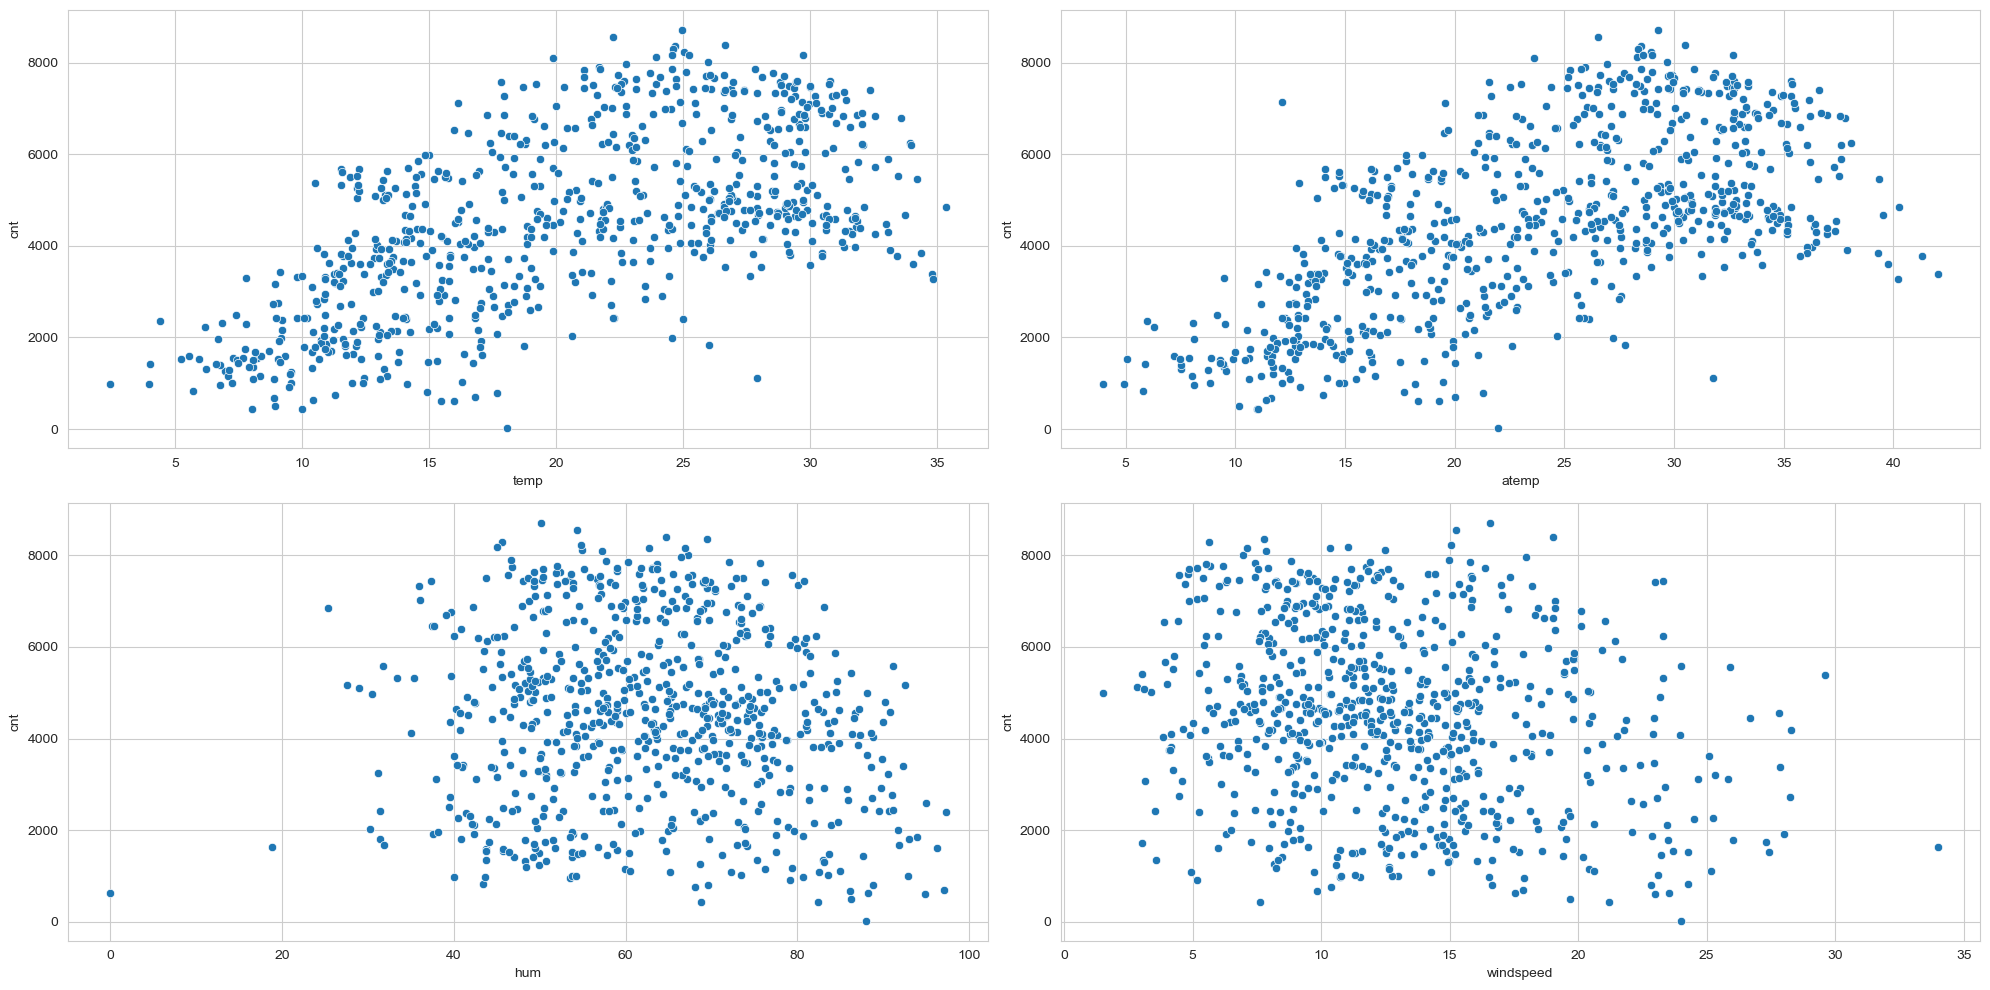

In [8]:
# Relationship between numerical variables and 'cnt'
numerical_vars = ['temp', 'atemp', 'hum', 'windspeed']

plt.figure(figsize=(20, 10))
for i, var in enumerate(numerical_vars, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=var, y='cnt', data=df)
plt.tight_layout()
plt.show()

The Exploratory Data Analysis (EDA) reveals several insights into how different variables relate to the total bike rentals (cnt):

Distribution of cnt: The distribution of total bike rentals shows a unimodal pattern with a slight skew to the right, indicating most days have a moderate number of rentals, with fewer days experiencing very high rentals.

Categorical Variables:

Season: There's a clear variation in bike rentals across different seasons, with fall showing higher medians and summer and fall having higher quartiles compared to spring and winter, indicating higher bike demand.
Year (yr): The boxplot shows an increase in bike rentals in 2019 compared to 2018, which supports the notion that the demand for bikes is growing annually.
Month (mnth): Bike rentals appear to vary by month, with higher rentals in warmer months (May to October) and lower rentals in colder months (November to February), reflecting seasonal impacts on bike usage.
Holiday: On holidays, the median rental count is slightly lower than on non-holidays, which could be due to people staying at home or traveling out of the city.
Weekday and Working Day: These variables show that the day of the week and whether it's a working day or not seem to have a less pronounced effect on the median bike rentals, suggesting that bike usage is relatively consistent across the week.
Numerical Variables:

Temperature (temp and atemp): There is a positive correlation between temperature and bike rentals, indicating that warmer temperatures lead to more bike rentals. This relationship appears linear, suggesting that temperature is a strong predictor of bike demand.
Humidity (hum): The scatterplot suggests a more diffuse relationship between humidity and bike rentals, indicating other factors may interact with humidity to influence bike demand.
Wind Speed (windspeed): Wind speed shows a more scattered relationship with bike rentals, suggesting it may not be as strong a predictor as temperature.

In [9]:
# Dropping unnecessary columns
df_model = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

# Define categorical and numerical features
categorical_features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
numerical_features = ['temp', 'atemp', 'hum', 'windspeed']

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_model, columns=categorical_features, drop_first=True)

# Separate features and target variable for RFE
X_encoded = df_encoded.drop('cnt', axis=1)
y_encoded = df_encoded['cnt']

# Standardize numerical features
scaler = StandardScaler()
X_encoded[numerical_features] = scaler.fit_transform(X_encoded[numerical_features])

# Initialize and fit RFE
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=15)  # Adjust n_features_to_select as needed
rfe = rfe.fit(X_encoded, y_encoded)

# Summarize selected features
selected_features_rfe = X_encoded.columns[rfe.support_]
print("Selected features via RFE:", selected_features_rfe)

# Calculate VIF for the selected features
X_selected = X_encoded[selected_features_rfe]
vif_data = pd.DataFrame()
vif_data["Feature"] = X_selected.columns
vif_data["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(len(X_selected.columns))]

# Display VIFs
print("\nVIF for selected features:")
print(vif_data.sort_values(by="VIF", ascending=False))


Selected features via RFE: Index(['atemp', 'season_spring', 'season_winter', 'yr_1', 'mnth_3', 'mnth_5',
       'mnth_6', 'mnth_8', 'mnth_9', 'mnth_10', 'holiday_1', 'weekday_6',
       'workingday_1', 'weathersit_2', 'weathersit_3'],
      dtype='object')

VIF for selected features:
          Feature       VIF
12   workingday_1  3.326797
1   season_spring  3.021759
0           atemp  2.757116
2   season_winter  2.711398
3            yr_1  1.869508
9         mnth_10  1.661134
13   weathersit_2  1.540710
11      weekday_6  1.459923
7          mnth_8  1.424987
6          mnth_6  1.374173
5          mnth_5  1.289409
8          mnth_9  1.284127
4          mnth_3  1.225992
10      holiday_1  1.094635
14   weathersit_3  1.078462


In [10]:
import statsmodels.api as sm

# Add a constant to the selected features for statsmodels
X_selected_const = sm.add_constant(X_selected)

# Fit the model
model_sm = sm.OLS(y_encoded, X_selected_const).fit()

# Print the summary to see the coefficients and p-values
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     235.6
Date:                Tue, 13 Feb 2024   Prob (F-statistic):          2.19e-264
Time:                        13:43:34   Log-Likelihood:                -5909.3
No. Observations:                 730   AIC:                         1.185e+04
Df Residuals:                     714   BIC:                         1.192e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3377.1607    105.571     31.989

Insignificant Predictor: holiday_1 might be considered for removal due to its higher p-value, suggesting it does not significantly contribute to the model within the conventional 0.05 significance level.

In [21]:
categorical_features_adjusted = ['season', 'yr', 'mnth', 'weekday', 'workingday', 'weathersit']
X = df.drop(['cnt', 'dteday'], axis=1)  # Drop non-numeric and target variable columns
y = df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adjust the preprocessor to exclude 'holiday'
preprocessor_adjusted = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features_adjusted)
    ])


# Adjust the pipeline to use the updated preprocessor
pipeline_adjusted = Pipeline([
    ('preprocessor', preprocessor_adjusted),
    ('regressor', LinearRegression())
])

# Train the model using the adjusted pipeline
pipeline_adjusted.fit(X_train, y_train)

# Predict on the test set with the adjusted model
y_pred_adjusted = pipeline_adjusted.predict(X_test)

# Calculate R-squared score for the adjusted model
r2_adjusted = r2_score(y_test, y_pred_adjusted)
print(f'R-squared score with holiday feature excluded: {r2_adjusted}')


R-squared score with holiday feature excluded: 0.8622197952176319


In [19]:
coefficients = pipeline_adjusted.named_steps['regressor'].coef_

# Gettting feature names from the preprocessor
feature_names_transformed = preprocessor_adjusted.named_transformers_['cat'].get_feature_names_out(categorical_features_adjusted)
all_feature_names_transformed = numerical_features + list(feature_names_transformed)

# Matching coefficients with their corresponding feature names
coefficients_with_features = pd.DataFrame({
    'Feature': all_feature_names_transformed,
    'Coefficient': coefficients
})

# Calculating the absolute value of coefficients to determine their importance
coefficients_with_features['Absolute Coefficient'] = coefficients_with_features['Coefficient'].abs()

# Sort features by the absolute value of their coefficients, descending
top_10_features = coefficients_with_features.sort_values(by='Absolute Coefficient', ascending=False).head(10)

top_10_features


,Feature,Coefficient,Absolute Coefficient
27,weathersit_3,-2098.815183,2098.815183
7,yr_1,1970.703178,1970.703178
4,season_spring,-999.727426,999.727426
6,season_winter,758.959285,758.959285
15,mnth_9,746.128362,746.128362
25,workingday_1,567.528540,567.528540
9,mnth_3,521.307523,521.307523
0,temp,462.188140,462.188140
24,weekday_6,458.615935,458.615935
26,weathersit_2,-437.621347,437.621347


The table above lists the top 10 features based on the absolute value of their coefficients from the linear regression model, indicating their importance in predicting bike rentals. Here are the key insights:

Weathersit_Light Snow/Rain: This feature has the highest negative impact on bike rentals, with a coefficient of approximately -2098.82. This suggests that light snow or rain significantly reduces bike rentals.
Yr_1 (Year 2019): Indicates a strong positive impact on bike rentals, with a coefficient of around 1970.70, reflecting the increase in rentals in 2019 compared to the base year.
Season_Spring: Shows a significant negative effect, with a coefficient of about -999.73, indicating lower rentals in spring compared to the reference season.
Season_Winter and Mnth_9 (September): Both have positive coefficients, suggesting higher rentals in winter and September.
Workingday_1 and Weekday_6 (Saturday): These indicate higher rentals on working days and Saturdays, respectively.
Temp: As expected, temperature has a positive correlation with bike rentals.

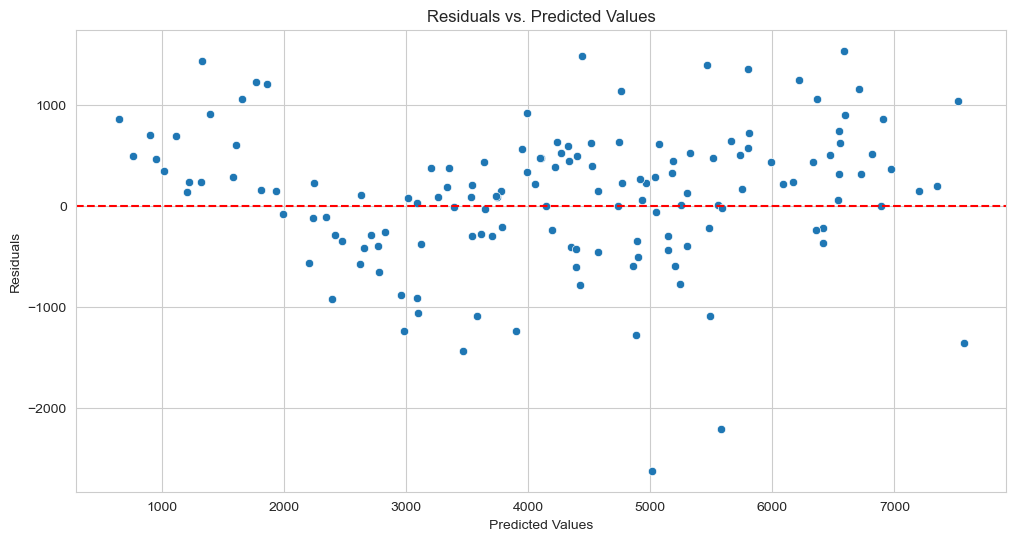

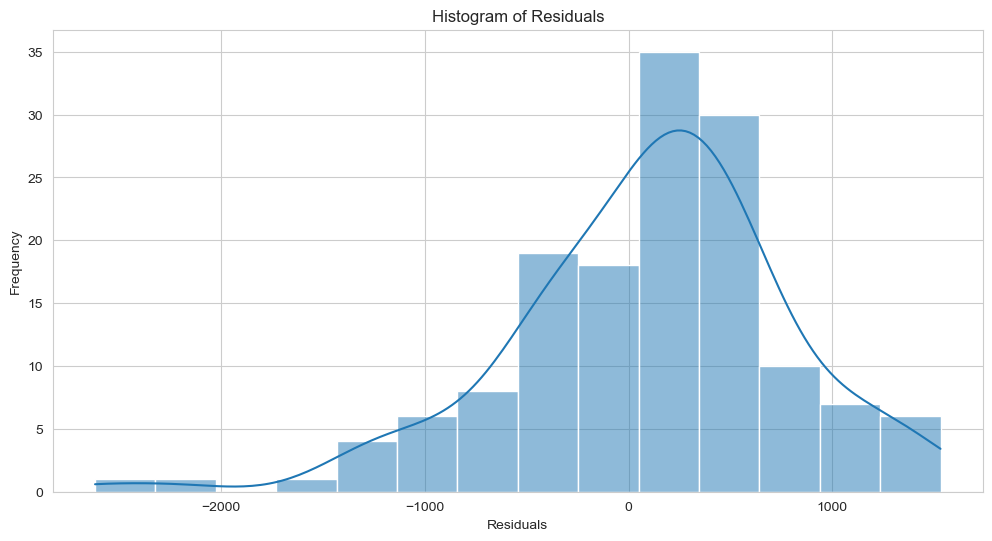

In [22]:
# Let's perform the residual analysis for the BoomBikes dataset using the model we've trained.

# Calculate residuals
residuals = y_test - y_pred_adjusted

# Plot Residuals vs. Predicted values
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred_adjusted, y=residuals)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

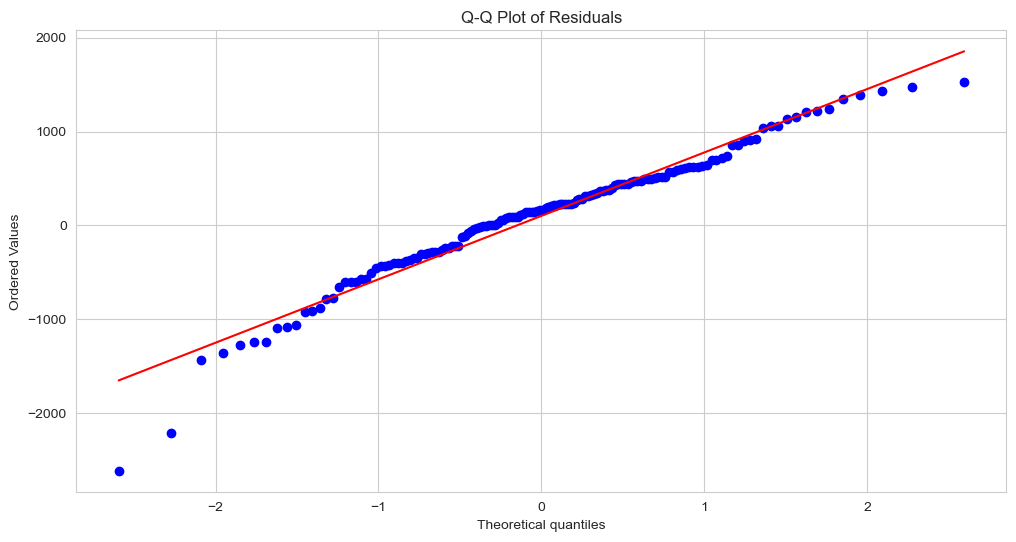

In [23]:
import scipy.stats as stats

# Q-Q Plot for residuals to check for normality
plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

Residuals vs. Predicted Values Plot: The residuals are generally scattered around the zero line without showing a clear pattern or systematic deviation. This suggests that the model does not suffer from obvious non-linearity or heteroscedasticity issues, indicating a good fit for the linear assumptions.

Histogram of Residuals: The histogram, supplemented by the Kernel Density Estimate (KDE), shows that the residuals are approximately normally distributed. This is a positive sign, as normality of residuals is one of the assumptions of linear regression, supporting the model's validity.

Q-Q Plot: The Q-Q plot appears to show that the residuals mostly follow the line, which would indicate normal distribution. However, any deviations from the line at the extremes could suggest minor issues with normality. Without significant deviation, we generally consider this assumption to be met.

Overall Implications
The residual analysis suggests that the linear regression model is reasonably well-fitted to the data, with residuals exhibiting properties that are consistent with key assumptions of linear regression (independence, homoscedasticity, and normality). There might be minor deviations, which are common in practical scenarios, but overall, the model appears to perform well for this dataset.